# Image Segmentation using UNet

## UNet Structure

![](images/Unet/unet.png)

## Import Packages

In [52]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt
import os
from progressbar import progressbar
import random
import pandas as pd

## Load Data

In [44]:
CAMERA_RGB_PATH = 'datasets/CARLA/CameraRGB/'
CAMERA_MASK_PATH = 'datasets/CARLA/CameraMask/'
IMAGE_SIZE = (96, 128) 
RGB_SHAPE = (96, 128, 3) 
MASK_SHAPE = (96, 128, 1)
N_FILTERS = 32
N_CLASSES = 23


# collect rgb files names
rgb_image_names = []
for file_name in os.listdir(CAMERA_RGB_PATH):
    rgb_image_names.append(file_name)
rgb_image_names.sort()


# collect mask files names
mask_image_names = []
for file_name in os.listdir(CAMERA_MASK_PATH):
    mask_image_names.append(file_name)
mask_image_names.sort()


image_names = list(zip(rgb_image_names, mask_image_names))
random.shuffle(image_names)

train_image_names = image_names[0 : int(0.6 * len(image_names))]
cv_image_names = image_names[int(0.6 * len(image_names)):
                             int(0.8 * len(image_names))]
test_image_names = image_names[int(0.8 * len(image_names)) :]



def process_one_image(image_path, resized_size, mask):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels = 3)
    if mask:
        img = tf.math.reduce_max(img, axis = -1, keepdims = True)
    else:
        img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, resized_size, method = 'nearest')

x_train = [] ; y_train = []
x_cv = [] ; y_cv = []
x_test = [] ; y_test = []


# collect train data
for file_name in progressbar( train_image_names ):
    ximg_path = os.path.join(CAMERA_RGB_PATH, file_name[0])
    yimg_path = os.path.join(CAMERA_MASK_PATH, file_name[1])
    
    x_train.append(process_one_image(ximg_path, IMAGE_SIZE, False))
    y_train.append(process_one_image(yimg_path, IMAGE_SIZE, True))

x_train = np.array(x_train)
y_train = np.array(y_train)



# collect cv data
for file_name in progressbar( cv_image_names ):
    ximg_path = os.path.join(CAMERA_RGB_PATH, file_name[0])
    yimg_path = os.path.join(CAMERA_MASK_PATH, file_name[1])
    
    x_cv.append(process_one_image(ximg_path, IMAGE_SIZE, False))
    y_cv.append(process_one_image(yimg_path, IMAGE_SIZE, True))
    
x_cv = np.array(x_cv)
y_cv = np.array(y_cv)


# collect test data
for file_name in progressbar( test_image_names ):
    ximg_path = os.path.join(CAMERA_RGB_PATH, file_name[0])
    yimg_path = os.path.join(CAMERA_MASK_PATH, file_name[1])
    
    x_test.append(process_one_image(ximg_path, IMAGE_SIZE, False))
    y_test.append(process_one_image(yimg_path, IMAGE_SIZE, True))

x_test = np.array(x_test)
y_test = np.array(y_test)


print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_cv shape: {x_cv.shape}")
print(f"y_cv shape: {y_cv.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


100% (636 of 636) |######################| Elapsed Time: 0:00:11 Time:  0:00:11
100% (212 of 212) |######################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (212 of 212) |######################| Elapsed Time: 0:00:03 Time:  0:00:03


x_train shape: (636, 96, 128, 3)
y_train shape: (636, 96, 128, 1)
x_cv shape: (212, 96, 128, 3)
y_cv shape: (212, 96, 128, 1)
x_test shape: (212, 96, 128, 3)
y_test shape: (212, 96, 128, 1)


Text(0.5, 1.0, 'y train')

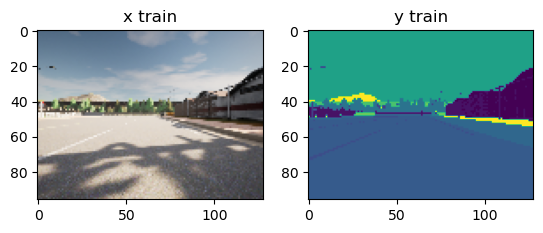

In [45]:
plt.subplot(121)
plt.imshow(x_train[0])
plt.title("x train")
plt.subplot(122)
plt.imshow(y_train[0])
plt.title("y train")

## Build Model

In [46]:
# The left part of UNet
def conv_block(inputs = None, 
               n_filters = None, 
               dropout_prob = 0, 
               max_pooling = None):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial 
                       dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  
        Next layer and skip connection outputs
    """

    conv = tfl.Conv2D(filters = n_filters,
                      kernel_size = (3, 3),
                      activation = 'elu',
                      padding ='same',
                      kernel_initializer = 'he_normal')(inputs)

    conv = tfl.Conv2D(filters = n_filters, 
                      kernel_size = (3, 3),
                      activation = 'relu',
                      padding ='same',
                      kernel_initializer = 'he_normal')(conv)
    
    if dropout_prob > 0:
        conv = tfl.Dropout(dropout_prob)(conv)
             
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = tfl.MaxPooling2D(pool_size = (2, 2),
                                      strides = (2, 2))(conv)
    else:
        next_layer = conv
        
    skip_connection = conv

    return next_layer, skip_connection

In [47]:
# The right part of UNet
def upsampling_block(expansive_input = None, 
                     contractive_input = None, 
                     n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = tfl.Conv2DTranspose(filters = n_filters,
                             kernel_size = (3, 3),
                             strides = (2, 2),
                             padding = 'same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = tfl.concatenate([up, contractive_input], axis=3)
    
    conv = tfl.Conv2D(filters = n_filters,
                      kernel_size = (3, 3),
                      activation = 'relu',
                      padding = 'same',
                      kernel_initializer='he_normal')(merge)
    
    conv = tfl.Conv2D(filters = n_filters,  
                      kernel_size = (3, 3),
                      activation = 'relu',
                      padding = 'same',
                      kernel_initializer = 'he_normal')(conv)
    return conv

In [48]:
def unet_model(input_size = None, 
               n_filters = None, 
               n_classes = None):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = tf.keras.layers.Input(input_size)
    
    conv_n_filters = n_filters
    cblock1 = conv_block(inputs = inputs,
                         dropout_prob = 0,
                         n_filters = conv_n_filters,
                         max_pooling = True)
    
    conv_n_filters *= 2
    cblock2 = conv_block(inputs = cblock1[0],
                         dropout_prob = 0,
                         n_filters = conv_n_filters,
                         max_pooling = True)
    
    conv_n_filters *= 2 
    cblock3 = conv_block(inputs = cblock2[0],
                         dropout_prob = 0,
                         n_filters = conv_n_filters,
                         max_pooling = True)
    
    conv_n_filters *= 2
    cblock4 = conv_block(inputs = cblock3[0],
                         dropout_prob = 0.3, 
                         n_filters = conv_n_filters,
                         max_pooling = True)
    
    conv_n_filters *= 2
    cblock5 = conv_block(inputs = cblock4[0],
                         dropout_prob = 0.3,
                         n_filters = conv_n_filters,
                         max_pooling = False)
    
    tconv_n_filters = n_filters * 8
    ublock6 = upsampling_block(expansive_input = cblock5[0],
                               contractive_input = cblock4[1],  
                               n_filters = tconv_n_filters)
    
    tconv_n_filters /= 2
    ublock7 = upsampling_block(expansive_input = ublock6,
                               contractive_input = cblock3[1],  
                               n_filters = tconv_n_filters)
    
    tconv_n_filters /= 2
    ublock8 = upsampling_block(expansive_input = ublock7,
                               contractive_input = cblock2[1],  
                               n_filters = tconv_n_filters)
    
    tconv_n_filters /= 2
    ublock9 = upsampling_block(expansive_input = ublock8,
                               contractive_input = cblock1[1],  
                               n_filters = tconv_n_filters)
    
    
    conv9 = tfl.Conv2D(filters = n_filters,
                       kernel_size = (3, 3),
                       activation='relu',
                       padding='same',
                       kernel_initializer='he_normal')(ublock9)

    
    conv10 = tfl.Conv2D(filters = n_classes,
                        kernel_size = (1, 1),
                        padding = 'same')(conv9)

    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [49]:
unet = unet_model(input_size = RGB_SHAPE,
                  n_filters = N_FILTERS,
                  n_classes = N_CLASSES)

unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_40 (Conv2D)             (None, 96, 128, 32)  896         ['input_3[0][0]']                
                                                                                                  
 conv2d_41 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_40[0][0]']              
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 48, 64, 32)  0           ['conv2d_41[0][0]']        

                                                                                                  
Total params: 8,640,471
Trainable params: 8,640,471
Non-trainable params: 0
__________________________________________________________________________________________________


In [50]:
unet.compile(optimizer = 'adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics = ['accuracy'])

unet.fit(x_train, 
         y_train, 
         epochs = 10,
         validation_data = (x_cv, y_cv))

Epoch 1/10


2023-08-01 18:37:51.942742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-01 18:37:52.156383: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


20/20 [==============================] - ETA: 0s - loss: 2.5665 - accuracy: 0.2936

2023-08-01 18:37:59.004811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 10s 365ms/step - loss: 2.5665 - accuracy: 0.2936 - val_loss: 1.8011 - val_accuracy: 0.5310
Epoch 2/10
20/20 [==============================] - 6s 303ms/step - loss: 1.4164 - accuracy: 0.6202 - val_loss: 0.9537 - val_accuracy: 0.7606
Epoch 3/10
20/20 [==============================] - 6s 304ms/step - loss: 0.7744 - accuracy: 0.8023 - val_loss: 0.7159 - val_accuracy: 0.8196
Epoch 4/10
20/20 [==============================] - 6s 303ms/step - loss: 0.6239 - accuracy: 0.8360 - val_loss: 0.5675 - val_accuracy: 0.8440
Epoch 5/10
20/20 [==============================] - 6s 301ms/step - loss: 0.5155 - accuracy: 0.8573 - val_loss: 0.4658 - val_accuracy: 0.8726
Epoch 6/10
20/20 [==============================] - 6s 300ms/step - loss: 0.4432 - accuracy: 0.8735 - val_loss: 0.4325 - val_accuracy: 0.8784
Epoch 7/10
20/20 [==============================] - 6s 300ms/step - loss: 0.4523 - accuracy: 0.8726 - val_loss: 0.4568 - val_accuracy: 0.8695
Epoch 8/10
20/20

<Axes: >

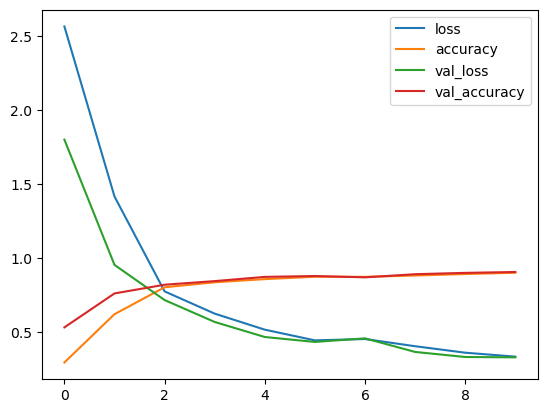

In [53]:
model_loss = pd.DataFrame(unet.history.history)
model_loss.plot()

In [54]:
unet.evaluate(x_test, y_test)

7/7 [==============================] - 1s 105ms/step - loss: 0.3395 - accuracy: 0.9016


[0.33947721123695374, 0.9016101956367493]

## Make Prediction

In [68]:
def generate_segmentation_image(model, input_image):
    '''
    Args:
    input_image : shape (n_H, n_W, n_C)
    
    Returns: shape (n_H, n_W, 1)
    '''
    input_image = np.expand_dims(input_image, axis = 0)
    output_image = model.predict(input_image)
    output_image = tf.argmax(output_image, axis = -1)
    output_image = np.expand_dims(output_image, axis = -1)
    return output_image[0]

1/1 [==============================] - 0s 53ms/step


Text(0.5, 1.0, 'Predicted Segmentation Image')

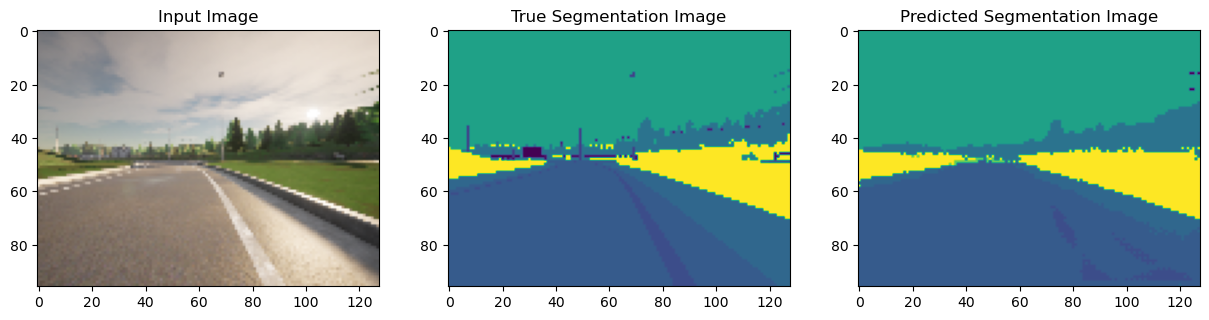

In [70]:
input_image = x_test[50]
true_segmentation_image = y_test[50]
predicted_segmentation_image = generate_segmentation_image(unet, 
                                                           input_image)
plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(true_segmentation_image)
plt.title('True Segmentation Image')

plt.subplot(1, 3, 3)
plt.imshow(predicted_segmentation_image)
plt.title('Predicted Segmentation Image')

1/1 [==============================] - 0s 44ms/step


Text(0.5, 1.0, 'Predicted Segmentation Image')

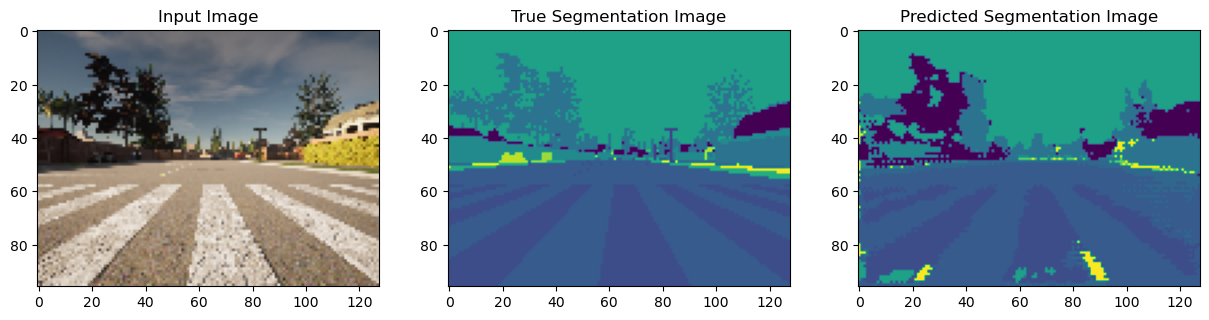

In [71]:
input_image = x_test[100]
true_segmentation_image = y_test[100]
predicted_segmentation_image = generate_segmentation_image(unet, 
                                                           input_image)
plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(true_segmentation_image)
plt.title('True Segmentation Image')

plt.subplot(1, 3, 3)
plt.imshow(predicted_segmentation_image)
plt.title('Predicted Segmentation Image')